# Data Preparation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
TRAIN_PATH = "/content/drive/MyDrive/DeepLearning_Models/UNET /data/stage1_train/stage1_train.zip (Unzipped Files)"
TEST_PATH = "/content/drive/MyDrive/DeepLearning_Models/UNET /data/stage1_test/stage1_test.zip (Unzipped Files)"

In [3]:
import os
import cv2
from tqdm.notebook import tqdm
import numpy as np
from skimage.io import imread
from skimage.transform import resize

In [4]:
train_idx = next(os.walk(TRAIN_PATH))[1]
test_idx = next(os.walk(TEST_PATH))[1]

In [5]:
print(len(train_idx), len(test_idx))

670 65


In [ ]:
# Loop through train and test set 
# Images inside train id is a normal image 
# Mask folder has multiple images segmented everytime
# We need to map mask folder with the original image

X_train = np.zeros((len(train_idx), 128, 128, 3), dtype = np.uint8)  # colored image accepted
y_train = np.zeros((len(train_idx), 128, 128, 1), dtype = np.uint8)  # black image then fill the segments

X_test = np.zeros((len(test_idx), 128, 128, 3), dtype = np.uint8)  # colored image accepted

In [ ]:
for e, imgs in tqdm(enumerate(train_idx), total=len(train_idx)):
  path = f"{TRAIN_PATH}/{imgs}/images/{imgs}.png"
  image = imread(path)[:,:,:3]
  resized_image = resize(image, (128,128), mode="constant", preserve_range=True)
  X_train[e] = resized_image
  mask = np.zeros((128, 128, 1), dtype = np.bool)
  for mask_file in next(os.walk(f'{TRAIN_PATH}/{imgs}/masks/'))[2]: 
    masked_image = imread(f'{TRAIN_PATH}/{imgs}/masks/{mask_file}')
    masked_image = np.expand_dims(resize(masked_image, (128,128), mode="constant",
                                         preserve_range=True), axis=-1)
    mask = np.maximum(mask, masked_image)
  y_train[e] = mask

In [ ]:
np.save("/content/drive/MyDrive/DeepLearning_Models/UNET /data/xtrain.npy", X_train)
np.save("/content/drive/MyDrive/DeepLearning_Models/UNET /data/ytrain.npy", y_train)

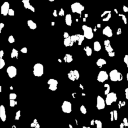

In [8]:
from google.colab.patches import cv2_imshow
cv2_imshow(y_train[1])

In [ ]:
for e, imgs in tqdm(enumerate(test_idx), total=len(test_idx)):
  path = f"{TEST_PATH}/{imgs}/images/{imgs}.png"
  image = imread(path)[:,:,:3]
  resized_image = resize(image, (128,128), mode="constant", preserve_range=True)
  X_test[e] = resized_image

In [ ]:
np.save("/content/drive/MyDrive/DeepLearning_Models/UNET /data/xtest.npy", X_test)

In [6]:
X_test = np.load(r"/content/drive/MyDrive/DeepLearning_Models/UNET /data/xtest.npy")
X_train = np.load(r"/content/drive/MyDrive/DeepLearning_Models/UNET /data/xtrain.npy")
y_train = np.load(r"/content/drive/MyDrive/DeepLearning_Models/UNET /data/ytrain.npy")

In [55]:
y_train.shape

(670, 128, 128, 1)

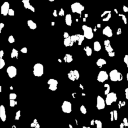

In [9]:
cv2_imshow(y_train[1])

# Model

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, \
                                    Input, Concatenate, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

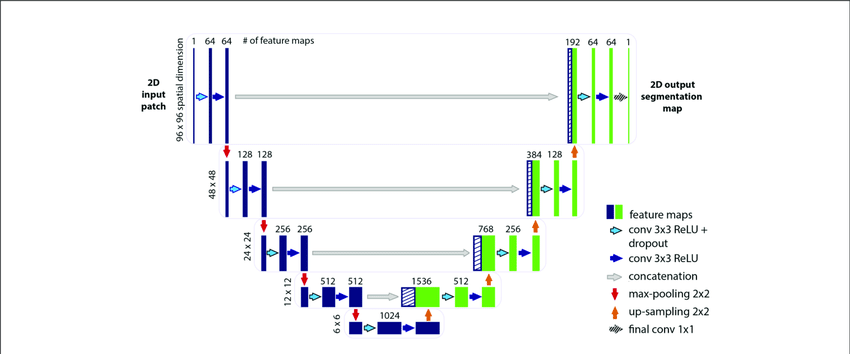

In [41]:
input = Input((128,128,3), name='input')
x = Lambda(lambda x: x / 255)(input)

# Encoder Block  (filters custom - 16, 32, 64, 128, 256)
c1 = Conv2D(16, (3,3), padding="same", activation="relu", name="conv1_1")(x)
c1 = Dropout(0.2)(c1)
c1 = Conv2D(16, (3,3), padding="same", activation="relu", name="conv1_2")(c1)

c2 = MaxPooling2D((2,2), padding="same", name="pool1_1")(c1)
c2 = Conv2D(32, (3,3), padding="same", activation="relu", name="conv2_1")(c2)
c2 = Dropout(0.2)(c2)
c2 = Conv2D(32, (3,3), padding="same", activation="relu", name="conv2_2")(c2)

c3 = MaxPooling2D((2,2), padding="same",name="pool2_1")(c2)
c3 = Conv2D(64, (3,3), padding="same", activation="relu", name="conv3_1")(c3)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3,3), padding="same", activation="relu",name="conv3_2")(c3)

c4 = MaxPooling2D((2,2), padding="same",name="pool3_1")(c3)
c4 = Conv2D(128, (3,3), padding="same", activation="relu",name="conv4_1")(c4)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3,3), padding="same", activation="relu",name="conv4_2")(c4)

c5 = MaxPooling2D((2,2), padding="same",name="pool4_1")(c4)
c5 = Conv2D(256, (3,3), padding="same", activation="relu",name="conv5_1")(c5)
c5 = Dropout(0.2)(c5)
c5 = Conv2D(256, (3,3), padding="same", activation="relu",name="conv5_2")(c5)

# Decoder block (128, 64, 32, 16)
u1 = Conv2DTranspose(128, (3,3), padding="same",strides=(2,2))(c5)
u1 = Concatenate(axis=3)([u1, c4])
u1 = Conv2D(128, (3,3), padding="same", activation="relu")(u1)
u1 = Dropout(0.2)(u1)
u1 = Conv2D(128, (3,3), padding="same",activation="relu")(u1)

u2 = Conv2DTranspose(64, (3,3), padding="same",strides=(2,2))(u1)
u2 = Concatenate(axis=3)([u2, c3])
u2 = Conv2D(64, (3,3), padding="same",activation="relu")(u2)
u2 = Dropout(0.2)(u2)
u2 = Conv2D(64, (3,3), padding="same",activation="relu")(u2)

u3 = Conv2DTranspose(32, (3,3), padding="same", strides=(2,2))(u2)
u3 = Concatenate(axis=3)([u3, c2])
u3 = Conv2D(32, (3,3), padding="same",activation="relu")(u3)
u3 = Dropout(0.2)(u3)
u3 = Conv2D(32, (3,3), padding="same",activation="relu")(u3)

u4 = Conv2DTranspose(16, (3,3), padding="same", strides=(2,2))(u3)
u4 = Concatenate(axis=3)([u4, c1])
u4 = Conv2D(16, (3,3), padding="same",activation="relu")(u4)
u4 = Dropout(0.2)(u4)
u4 = Conv2D(16, (3,3), padding="same",activation="relu")(u4)

output = Conv2D(1, (1,1), padding="same")(u4)

model = Model(inputs=[input], outputs=[output])


In [42]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=['accuracy'])

In [19]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 128, 128, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 128, 128, 16) 448         lambda_2[0][0]                   
__________________________________________________________________________________________________
dropout_18 (Dropout)            (None, 128, 128, 16) 0           conv1_1[0][0]                    
____________________________________________________________________________________________

In [45]:
xtrain = X_train / 255.0
ytrain = y_train / 255.0
xtest = X_test / 255.0

In [50]:

#Build the model
inputs = tf.keras.layers.Input((128, 128, 3))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_8 (Lambda)               (None, 128, 128, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_131 (Conv2D)             (None, 128, 128, 16) 448         lambda_8[0][0]                   
__________________________________________________________________________________________________
dropout_72 (Dropout)            (None, 128, 128, 16) 0           conv2d_131[0][0]                 
____________________________________________________________________________________________

In [54]:
#Modelcheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpointer = ModelCheckpoint('/content/drive/MyDrive/DeepLearning_Models/UNET /model_for_nuclei.h5', 
                                                  verbose=1, save_best_only=True)

callbacks = [
        EarlyStopping(patience=25, monitor='val_loss')]

results = model.fit(X_train, y_train, validation_split=0.2,batch_size=1, epochs=25, callbacks=callbacks)

Epoch 1/25
536/536 [==============================] - 7s 10ms/step - loss: nan - accuracy: 0.8066 - val_loss: nan - val_accuracy: 0.8247
Epoch 2/25
299/536 [===============>..............] - ETA: 2s - loss: nan - accuracy: 0.8148

KeyboardInterrupt: ignored

In [30]:
import matplotlib.pyplot as plt
from skimage.io import imread, imshow

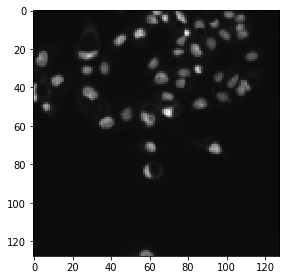

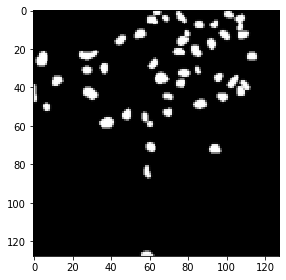

In [32]:
image_x = np.random.randint(0, 670)
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(y_train[image_x]))
plt.show()

3/3 [==============================] - 0s 12ms/step


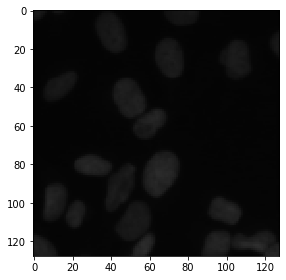

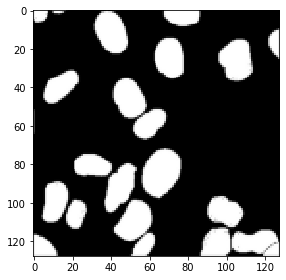

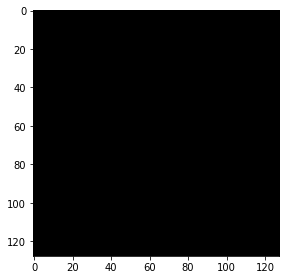

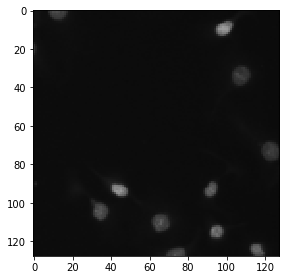

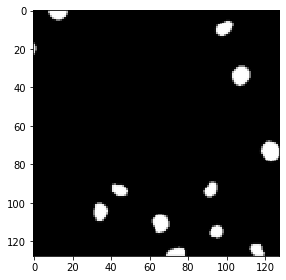

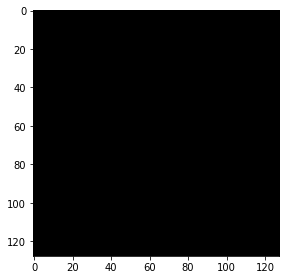

In [35]:
idx = np.random.randint(0, len(X_train))


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


# Perform a sanity check on some random training samples
ix = np.random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check on some random validation samples
ix = np.random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(y_train[int(y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()
